# Ensemble learning

In [1]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:10000]
y = mnist.target[:10000]

## Transformacja zbioru do przestrzeni 30D

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [6]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(10000, 2)

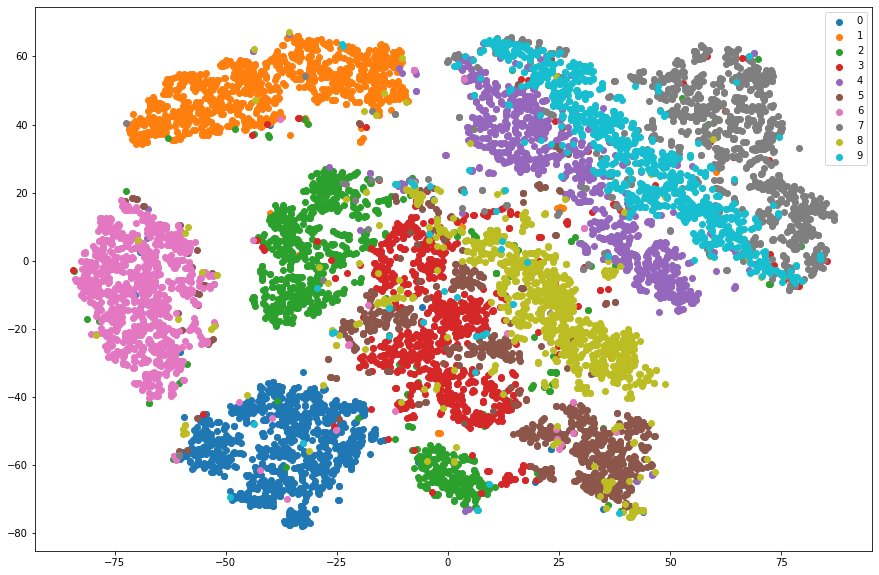

In [6]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [7]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

In [9]:
X_train.shape

(1566, 30)

## Bagging

W zależności od sposobu wyboru podzbiorów zbioru danych wyróżniamy różne rodzaje tego algorytmu:

- **pasting** - wybór losowych podzbiorów próbek
- **bagging** - wybór losowych podzbiorów próbek ze zwracaniem
- **random subspaces** - wybór losowych podzbiorów cech
- **random patches** - wybór losowych podzbiorów próbek i cech

W praktyce wybór metody sprowadza się do odpowiedniego ustawienia zmiennych w klasyfikatorze BaggingClassifier.
Szczegółowy opis można znaleźć w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) sklearn.

#### Klasyczny bagging

Jak zostało wyżej wspomniane - w tej metodzie wybieramy losowo podzbory próbek ze zwracaniem. Jest to domyślny wariant klasyfikatora BaggingClassifier.

In [10]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        max_samples=0.5).fit(X_train, y_train)

In [11]:
clf.score(X_test, y_test)

0.9693877551020408

Metody grupowania są silnie uzależnione od ilości klasyfikatorów oraz ilości próbek, których użyjemy do ich trenowania. Możemy w prosty sposób zwizualizować tą zależność:

In [12]:
def ensemble_scores(clf, estimators, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_samples in samples:
            fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             max_samples=max_samples).fit(X_train, y_train)
            yield n_estimators, max_samples, fitted_clf.score(X_test, y_test)

            
def visualize_ensemble(clf, n_estimators, max_samples, base_estimator=None):
    values = np.array(list(ensemble_scores(clf, n_estimators, max_samples, base_estimator)))
    X = values[:,0]
    Y = values[:,1]
    Z = values[:,2]
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis')

In [ ]:
estimators = np.arange(5, 200, 10)
samples = np.linspace(0.1, 1., num=20)

visualize_ensemble(BaggingClassifier, estimators, samples, base_estimator=SVC())

#### Random subspace

Metoda random subspace od zwykłego baggingu różni się tym, że wybieramy podzbiory cech zamiast podzbiorów próbek. Ustawiamy flagi:
- **bootstrap_features=True** - wybieramy cechy ze zwracaniem
- **max_samples=1.0 (default)** - nie losujemy próbek (bierzemy wszystkie)
- **max_features=n** - ilość losowanych cech

In [13]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5).fit(X_train, y_train)

In [14]:
clf.score(X_test, y_test)

0.9362244897959183

#### Random patching

Połączenie powyższych metod nazywamy _random patching_. Ze zbioru losujemy i próbki, i cechy.

In [15]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5,
                        max_samples=0.6).fit(X_train, y_train)

In [16]:
clf.score(X_test, y_test)

0.951530612244898

### Zadanie
1. Zwizualizuj za pomocą tabeli zależność powyższych metod od *n_estimators* i *max_samples*/*max_features*.
2. Odpowiedz na pytanie: jak zmienia się dokładność klasyfikacji dla różnych metod określana finalnej decyzji (normalna średnia, majority vote, etc.)

In [17]:
import math

estimators = np.arange(5, 105, 15)
samples = np.arange(1, 10, 1)
features = np.arange(1, 10, 1) 

def ensemble_scores_random_patching(estimators, samples, features):
    results = []
    for n_estimators in estimators:
        for sample in samples:
            for feature in features:
                clf = BaggingClassifier(base_estimator=SVC(),
                            n_estimators=5,
                            bootstrap_features=True,
                            max_features=feature/10,
                            max_samples=sample/10).fit(X_train, y_train)
                result = [n_estimators, sample/10, feature/10, math.floor(1000*sample/feature)/1000, clf.score(X_test, y_test)]
                results.append(result)
    return results

values = ensemble_scores_random_patching(estimators, samples, features)

In [18]:
import pandas as pd
pd.set_option('display.max_rows', 200)

print(pd.DataFrame(data=values, columns=["N", "SAMPLES", "FEATURES", "S/F", "ACC"]).sort_values(by=["ACC"]).sample(20))

      N  SAMPLES  FEATURES    S/F       ACC
338  65      0.2       0.6  0.333  0.938776
464  80      0.7       0.6  1.166  0.943878
11    5      0.2       0.3  0.666  0.936224
115  20      0.4       0.8  0.500  0.971939
240  35      0.9       0.7  1.285  0.954082
29    5      0.4       0.3  1.333  0.946429
269  50      0.3       0.9  0.333  0.928571
284  50      0.5       0.6  0.833  0.943878
432  80      0.4       0.1  4.000  0.823980
224  35      0.7       0.9  0.777  0.966837
439  80      0.4       0.8  0.500  0.964286
556  95      0.8       0.8  1.000  0.956633
379  65      0.7       0.2  3.500  0.857143
33    5      0.4       0.7  0.571  0.966837
5     5      0.1       0.6  0.166  0.933673
61    5      0.7       0.8  0.875  0.964286
274  50      0.4       0.5  0.800  0.951531
163  35      0.1       0.2  0.500  0.875000
500  95      0.2       0.6  0.333  0.938776
524  95      0.5       0.3  1.666  0.933673


## Random Forest


Metoda Random Forest różni się od baggingu przede wszystkim tym, że cechy wybierane są losowo spośród wszystkich i najlepszy podział z podzbioru zostaje użyty do dzielenia węzłów w drzewie.
W baggingu natomiast podczas dzielenia węzłów bierze się pod uwagę wszystkie cechy.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) sklearn.

In [19]:
clf = RandomForestClassifier(n_estimators=5,
                             max_samples=0.5).fit(X_train, y_train)

In [20]:
clf.score(X_test, y_test)

0.8877551020408163

## Ada Boost

Metoda, która agreguje wiele słabszych klasyfikatorów w jeden większy. W odróżnieniu od baggingu waga drzew nie jest jednakowa.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier) sklearn.

In [21]:
clf = AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

In [22]:
clf.score(X_test, y_test)

0.8163265306122449

## Projekt indywidualny


Dokonaj analizy zbioru danych FMNIST za pomocą wyżej wymienionych klasyfikatorów.

In [23]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)
X = mnist.data[:10000]
y = mnist.target[:10000]

1. Ze zbioru wybierz dwie trudno rozdzielalne cechy i wykorzystaj je do dalszej analizy.
2. Sprawdź wydajność klasyfikatorów Bagging, RandomForest i AdaBoost dla powstałego zbioru.
3. Dla każdego zbioru sprawdź zależność wyniku od ilości klasyfikatorów bazowych. Zaprezentuj wyniki w tabelce. 

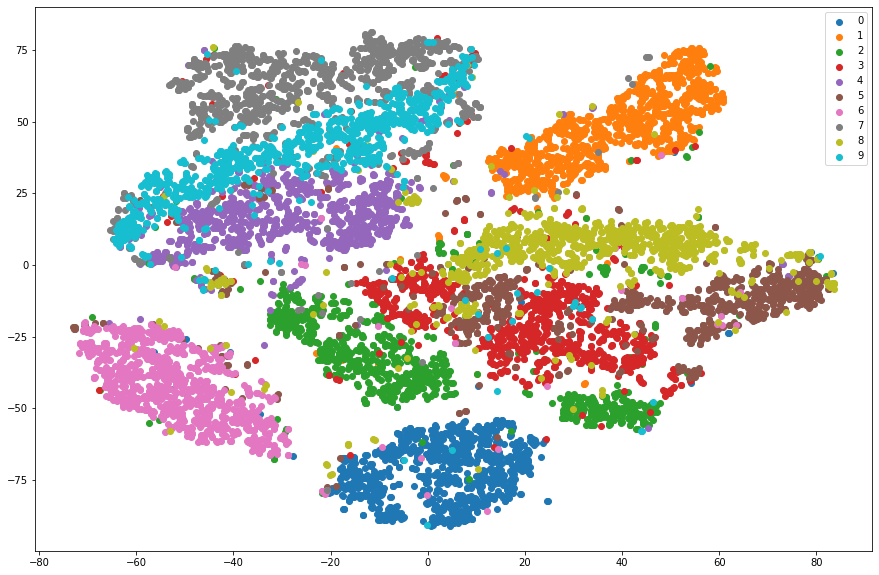

In [24]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wybrałem cechy 7 i 9

In [25]:
filter = np.where((y == '7') | (y == '9'))
X_filtered, y_filtered = X_pca[filter], y[filter]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)
X_train.shape

(1638, 30)

In [29]:
clfs_names = ["Bagging", "Forest", "Ada"]

def get_clf(classifier, n_estimators):
    if classifier == "Bagging":
        return BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5,
                        max_samples=0.6).fit(X_train, y_train)
    elif classifier == "Forest":
        return RandomForestClassifier(n_estimators=5,
                        max_samples=0.9).fit(X_train, y_train)
    else:
        return AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

print("Classifier\tAccurancy")
for name in clfs_names:
    print(name + "\t\t" + str(get_clf(name, 5).fit(X_train, y_train).score(X_test, y_test)))

Classifier	Accurancy
Bagging		0.9390243902439024
Forest		0.9
Ada		0.8536585365853658


In [32]:
import time

estimators = np.arange(5, 215, 15)
results = []

for i in range(len(clfs_names)):
    for n_estimators in estimators:
        score = get_clf(clfs_names[i], n_estimators).score(X_test, y_test)
        results.append([clfs_names[i], n_estimators, math.floor(1000*score)/1000])

In [33]:
print(pd.DataFrame(data=results, columns=["CLASS", "N", "ACC"]).tail(100))

      CLASS    N    ACC
0   Bagging    5  0.917
1   Bagging   20  0.934
2   Bagging   35  0.929
3   Bagging   50  0.914
4   Bagging   65  0.926
5   Bagging   80  0.931
6   Bagging   95  0.931
7   Bagging  110  0.917
8   Bagging  125  0.934
9   Bagging  140  0.926
10  Bagging  155  0.939
11  Bagging  170  0.929
12  Bagging  185  0.919
13  Bagging  200  0.917
14   Forest    5  0.892
15   Forest   20  0.897
16   Forest   35  0.926
17   Forest   50  0.924
18   Forest   65  0.909
19   Forest   80  0.909
20   Forest   95  0.900
21   Forest  110  0.887
22   Forest  125  0.900
23   Forest  140  0.912
24   Forest  155  0.904
25   Forest  170  0.900
26   Forest  185  0.909
27   Forest  200  0.904
28      Ada    5  0.853
29      Ada   20  0.853
30      Ada   35  0.853
31      Ada   50  0.853
32      Ada   65  0.853
33      Ada   80  0.853
34      Ada   95  0.853
35      Ada  110  0.853
36      Ada  125  0.853
37      Ada  140  0.853
38      Ada  155  0.853
39      Ada  170  0.853
40      Ada  185